In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sqlalchemy import create_engine
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [3]:
import chardet
with open('Games.csv', 'rb') as f:
    result = chardet.detect(f.read())
with open('Games.csv', 'r', encoding=result['encoding']) as f:
    content = f.read()
with open('Games_UTF8.csv', 'w', encoding='utf-8') as f:
    f.write(content)    
print("File has been converted to UTF-8 and saved as 'Games_UTF8.csv'")

File has been converted to UTF-8 and saved as 'Games_UTF8.csv'


In [8]:
data_url = 'Games_UTF8.csv'  
Games_df = pd.read_csv(data_url)

In [15]:

Games_df = Games_df.dropna(subset=["Year_of_Release", "Genre", "Publisher", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales", "Critic_Score", "Critic_Count", "User_Score", "User_Count", "Developer"])
Games_df

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16677,Mortal Kombat: Deadly Alliance,GBA,2002.0,Fighting,Midway Games,0.01,0.00,0.00,0.00,0.01,81.0,12.0,8.8,9.0,Criterion Games,M
16696,Metal Gear Solid V: Ground Zeroes,PC,2014.0,Action,Konami Digital Entertainment,0.00,0.01,0.00,0.00,0.01,80.0,20.0,7.6,412.0,Kojima Productions,M
16700,Breach,PC,2011.0,Shooter,Destineer,0.01,0.00,0.00,0.00,0.01,61.0,12.0,5.8,43.0,Atomic Games,T
16706,STORM: Frontline Nation,PC,2011.0,Strategy,Unknown,0.00,0.01,0.00,0.00,0.01,60.0,12.0,7.2,13.0,SimBin,E10+


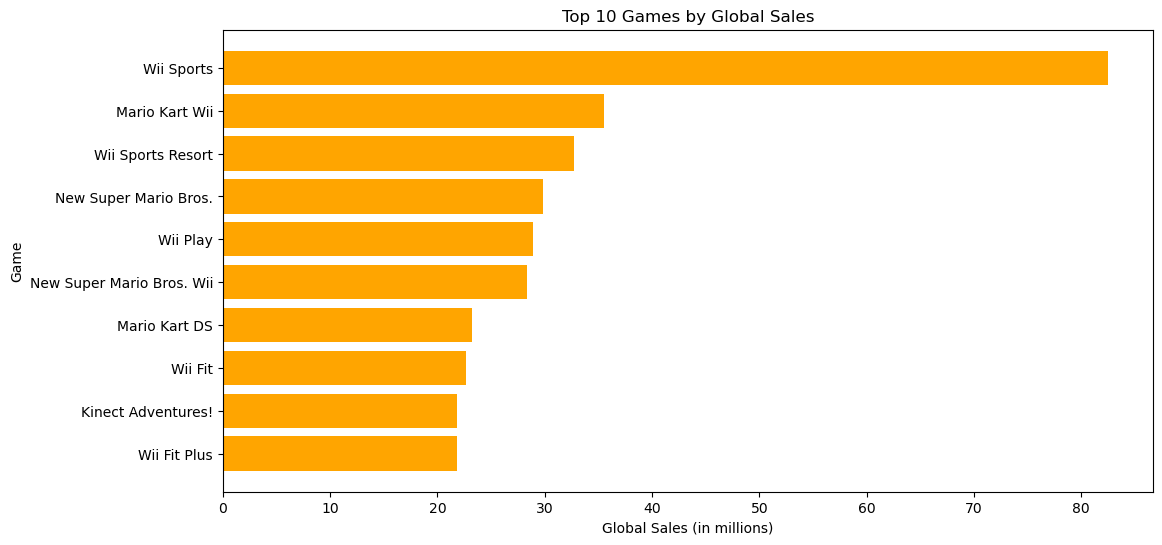

In [35]:
# Top 10 games by global sales
top_10_games = Games_df.nlargest(10, 'Global_Sales')[['Name', 'Global_Sales']]
# Plotting top 10 games by global sales
plt.figure(figsize=(12, 6))
plt.barh(top_10_games['Name'], top_10_games['Global_Sales'], color='orange')
plt.title('Top 10 Games by Global Sales')
plt.xlabel('Global Sales (in millions)')
plt.ylabel('Game')
plt.gca().invert_yaxis()
plt.show()

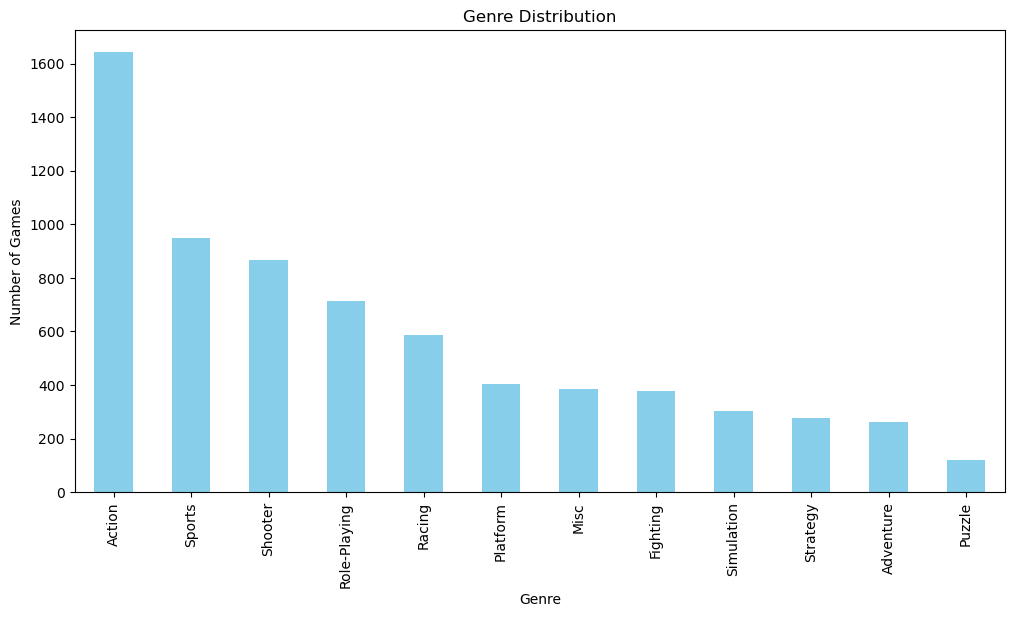

In [39]:
#Genre Distribution
#Next, let’s analyze the distribution of game genres:
# Genre distribution
genre_distribution = Games_df['Genre'].value_counts()
# Plotting genre distribution
plt.figure(figsize=(12, 6))
genre_distribution.plot(kind='bar', color='skyblue')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Number of Games')
plt.show()

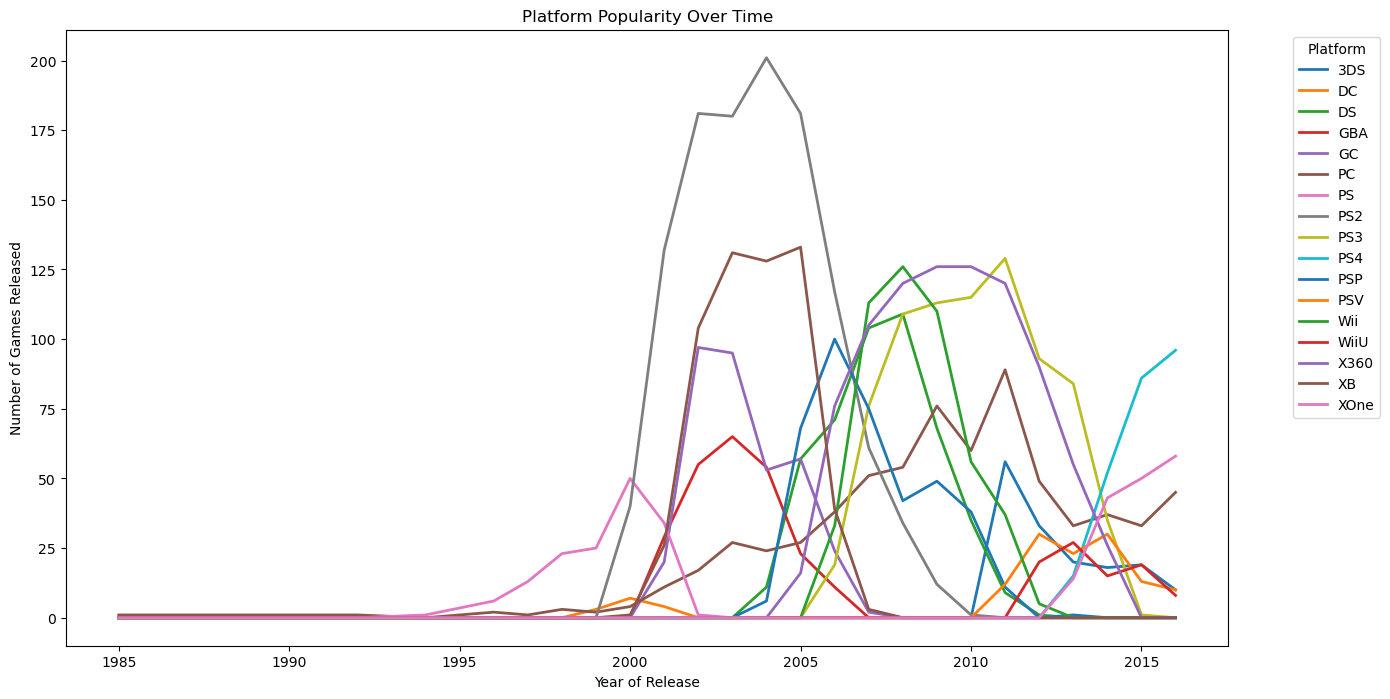

In [41]:
# Filter out rows with missing 'Year_of_Release'
Games_df_filtered = Games_df.dropna(subset=['Year_of_Release'])
# Convert 'Year_of_Release' to integer
Games_df_filtered['Year_of_Release'] = Games_df_filtered['Year_of_Release'].astype(int)
# Group by year and platform
platform_popularity = Games_df_filtered.groupby(['Year_of_Release', 'Platform']).size().unstack().fillna(0)
# Plotting platform popularity over time
plt.figure(figsize=(15, 8))
platform_popularity.plot(ax=plt.gca(), kind='line', linewidth=2)
plt.title('Platform Popularity Over Time')
plt.xlabel('Year of Release')
plt.ylabel('Number of Games Released')
plt.legend(title='Platform', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

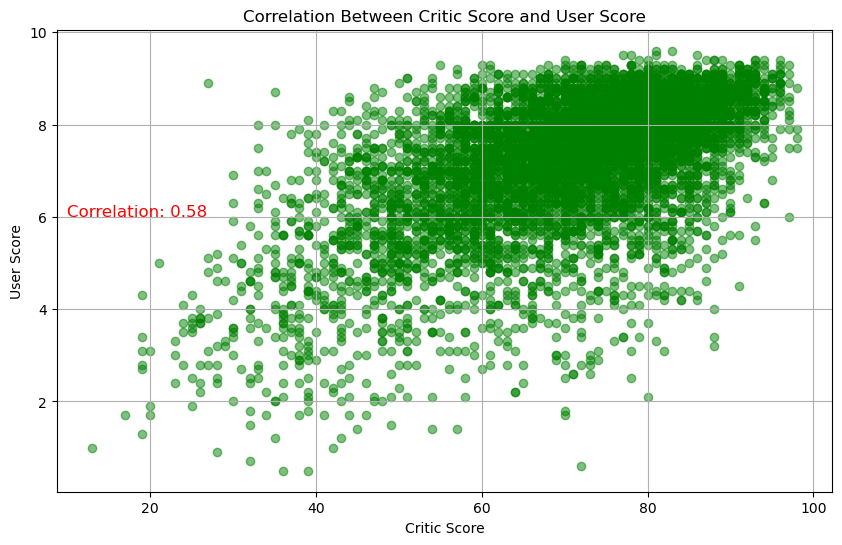

In [83]:
#Correlation Between Critic and User Scores
# Filter out rows with missing 'Critic_Score' and 'User_Score'
Games_df_scores = Games_df_scores.dropna(subset=['Critic_Score', 'User_Score'])
# Convert 'User_Score' to numeric, handling errors
Games_df_scores['User_Score'] = pd.to_numeric(Games_df_scores['User_Score'], errors='coerce')
# Drop rows with NaN values after conversion
Games_df_scores = Games_df_scores.dropna(subset=['User_Score'])
# Plotting the correlation
plt.figure(figsize=(10, 6))
plt.scatter(Games_df_scores['Critic_Score'], Games_df_scores['User_Score'], alpha=0.5, color='green')
plt.title('Correlation Between Critic Score and User Score')
plt.xlabel('Critic Score')
plt.ylabel('User Score')
plt.grid(True)
plt.text(10, 6, f'Correlation: {correlation:.2f}', fontsize=12, color='red')
plt.show()

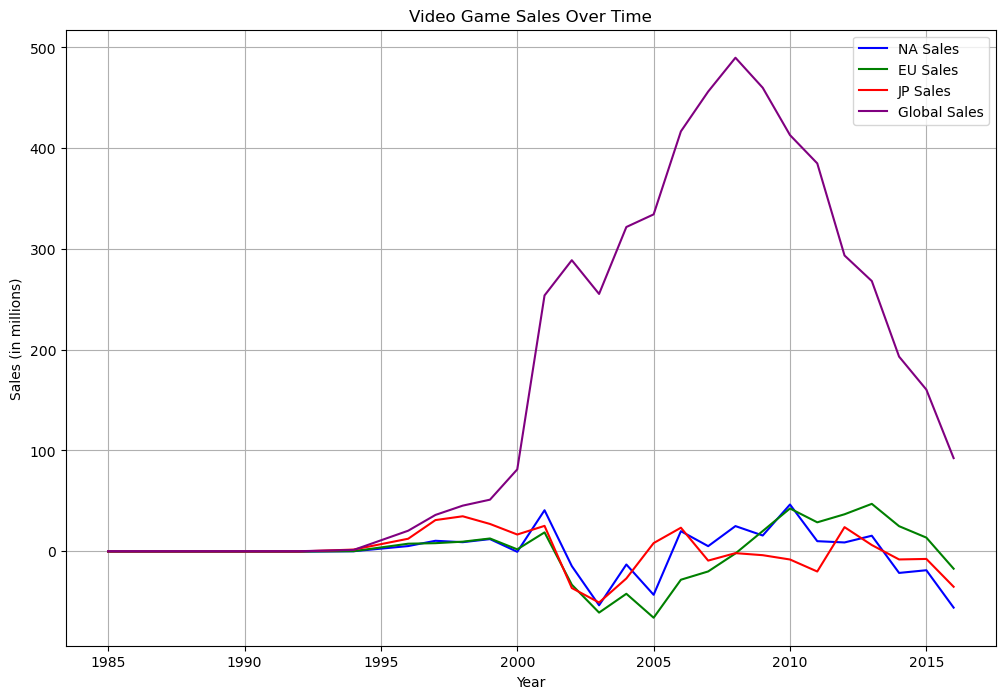

In [63]:
# Yearly Aggregate Sales
Games_df['Year_of_Release'] = pd.to_datetime(Games_df['Year_of_Release'], format='%Y')

# Aggregate sales data by year
sales_over_time = Games_df.groupby(Games_df['Year_of_Release'].dt.year)[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales']].sum()
# Plotting sales over time
plt.figure(figsize=(12, 8))
plt.plot(sales_over_time.index, sales_over_time['NA_Sales'], label='NA Sales', color='blue')
plt.plot(sales_over_time.index, sales_over_time['EU_Sales'], label='EU Sales', color='green')
plt.plot(sales_over_time.index, sales_over_time['JP_Sales'], label='JP Sales', color='red')
plt.plot(sales_over_time.index, sales_over_time['Global_Sales'], label='Global Sales', color='purple')

plt.title('Video Game Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales (in millions)')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
print(monthly_sales_pivot.columns)

Index(['Month_1'], dtype='object')


<Figure size 1400x800 with 0 Axes>

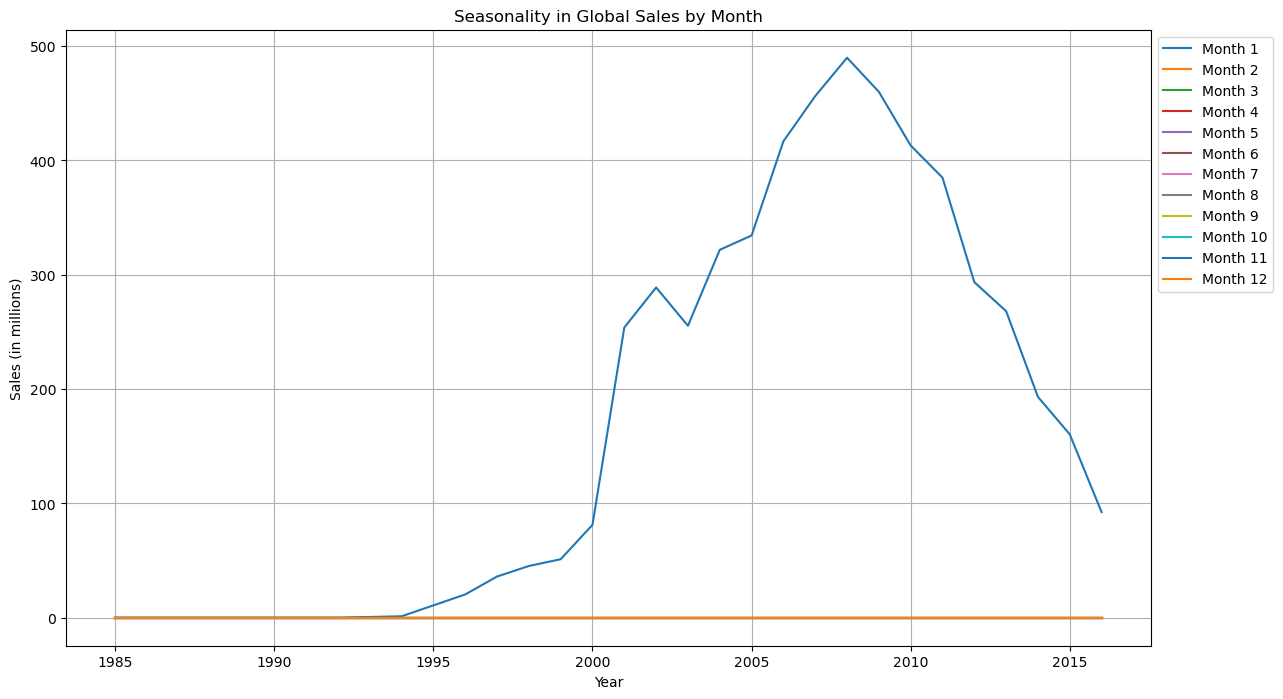

In [69]:
# Monthly Pattern in Sales
# Convert the Release_Date to datetime if it's not already in that format
Games_df['Year_of_Release'] = pd.to_datetime(Games_df['Year_of_Release'], format='%Y-%m-%d')

# Extract year and month
Games_df['Year'] = Games_df['Year_of_Release'].dt.year
Games_df['Month'] = Games_df['Year_of_Release'].dt.month

# Aggregate sales by month across all years
monthly_sales = Games_df.groupby(['Year', 'Month'])[['Global_Sales']].sum().reset_index()

# Pivot the data to have months as columns
monthly_sales_pivot = monthly_sales.pivot(index='Year', columns='Month', values='Global_Sales')
monthly_sales_pivot.columns = [f'Month_{month}' for month in monthly_sales_pivot.columns]

plt.figure(figsize=(14, 8))


all_months = [f'Month_{i}' for i in range(1, 13)]
monthly_sales_pivot = monthly_sales_pivot.reindex(columns=all_months, fill_value=0)

# Plotting as before
plt.figure(figsize=(14, 8))
for month in all_months:
    plt.plot(monthly_sales_pivot.index, monthly_sales_pivot[month], label=month.replace('Month_', 'Month '))

plt.title('Seasonality in Global Sales by Month')
plt.xlabel('Year')
plt.ylabel('Sales (in millions)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

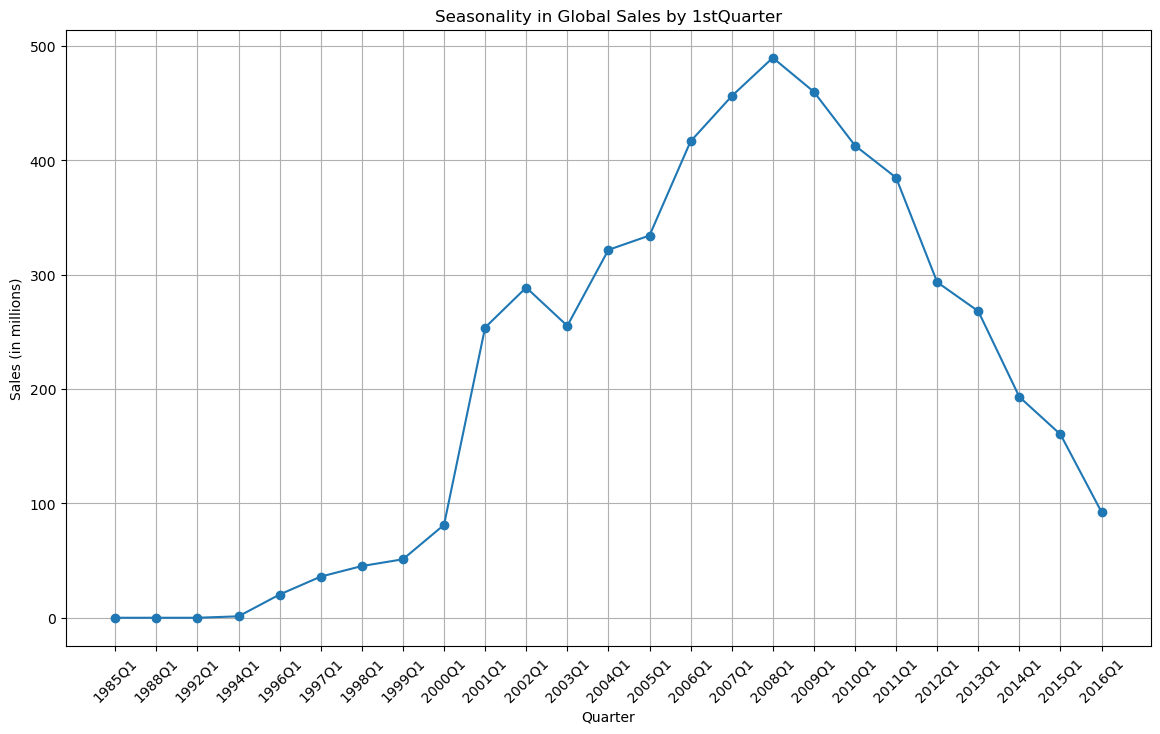

In [88]:
# 1st Quarterly Sales
# Extract quarter
Games_df['Quarter'] = Games_df['Year_of_Release'].dt.to_period('Q')

# Aggregate sales by quarter
quarterly_sales = Games_df.groupby('Quarter')[['Global_Sales']].sum().reset_index()

# Convert Quarter to string for better visualization
quarterly_sales['Quarter'] = quarterly_sales['Quarter'].astype(str)

# Plotting quarterly sales
plt.figure(figsize=(14, 8))
plt.plot(quarterly_sales['Quarter'], quarterly_sales['Global_Sales'], marker='o', linestyle='-')
plt.title('Seasonality in Global Sales by 1stQuarter')
plt.xlabel('Quarter')
plt.ylabel('Sales (in millions)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [72]:
#Regional Sales
# Aggregate total sales by region
sales_by_region = Games_df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].sum()

# Display the aggregated data
print(sales_by_region)


NA_Sales        2.273737e-13
EU_Sales        2.273737e-13
JP_Sales        0.000000e+00
Other_Sales     5.652700e+02
Global_Sales    5.317890e+03
dtype: float64


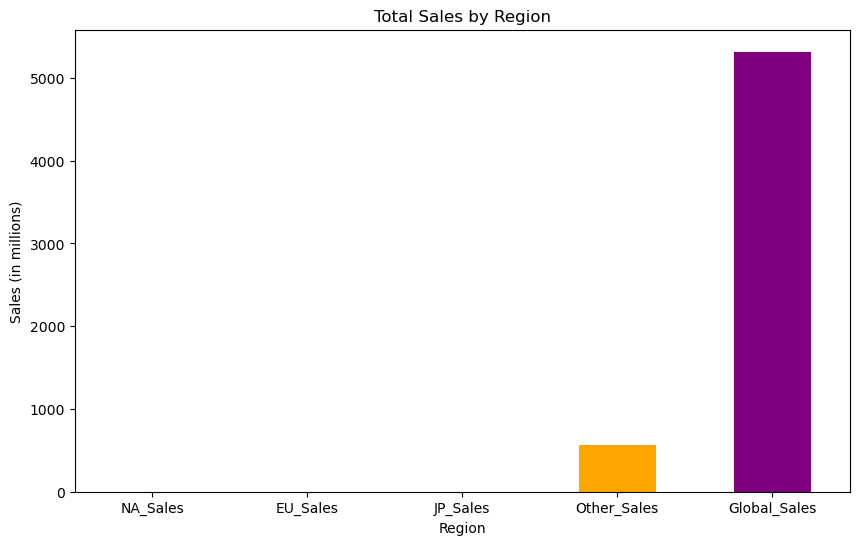

In [73]:
plt.figure(figsize=(10, 6))
sales_by_region.plot(kind='bar', color=['blue', 'green', 'red', 'orange', 'purple'])
plt.title('Total Sales by Region')
plt.xlabel('Region')
plt.ylabel('Sales (in millions)')
plt.xticks(rotation=0)
plt.show()

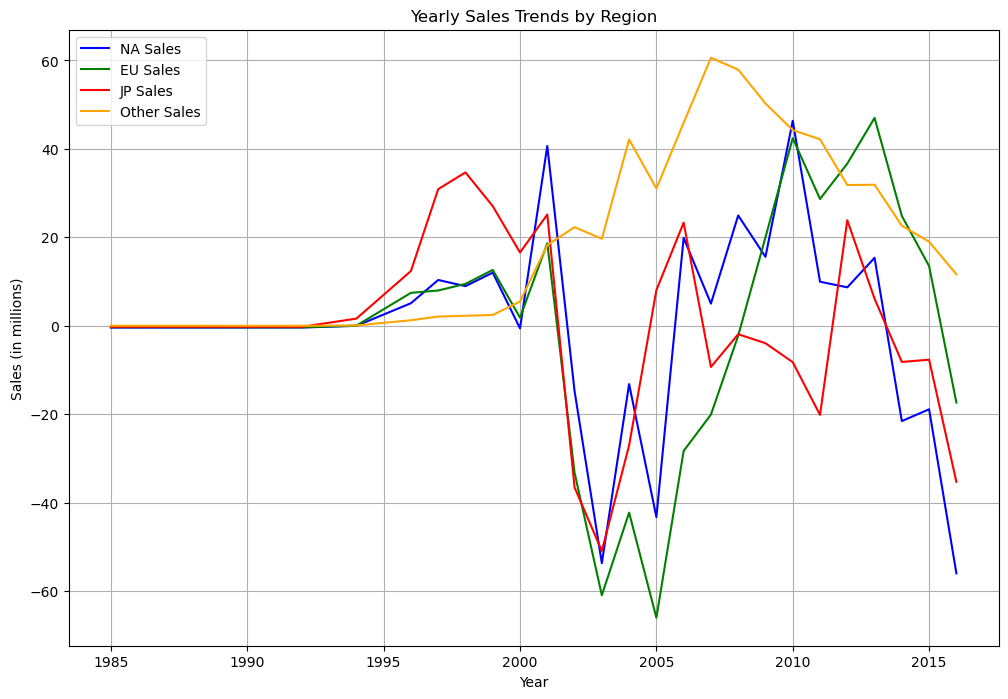

In [74]:
# Yearly Sales by Region

# Convert 'Year_of_Release' to datetime format if necessary
Games_df['Year_of_Release'] = pd.to_datetime(Games_df['Year_of_Release'], format='%Y')

# Aggregate sales by year for each region
yearly_sales_by_region = Games_df.groupby(Games_df['Year_of_Release'].dt.year)[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()

# Plot sales trends over time
plt.figure(figsize=(12, 8))
plt.plot(yearly_sales_by_region.index, yearly_sales_by_region['NA_Sales'], label='NA Sales', color='blue')
plt.plot(yearly_sales_by_region.index, yearly_sales_by_region['EU_Sales'], label='EU Sales', color='green')
plt.plot(yearly_sales_by_region.index, yearly_sales_by_region['JP_Sales'], label='JP Sales', color='red')
plt.plot(yearly_sales_by_region.index, yearly_sales_by_region['Other_Sales'], label='Other Sales', color='orange')

plt.title('Yearly Sales Trends by Region')
plt.xlabel('Year')
plt.ylabel('Sales (in millions)')
plt.legend()
plt.grid(True)
plt.show()

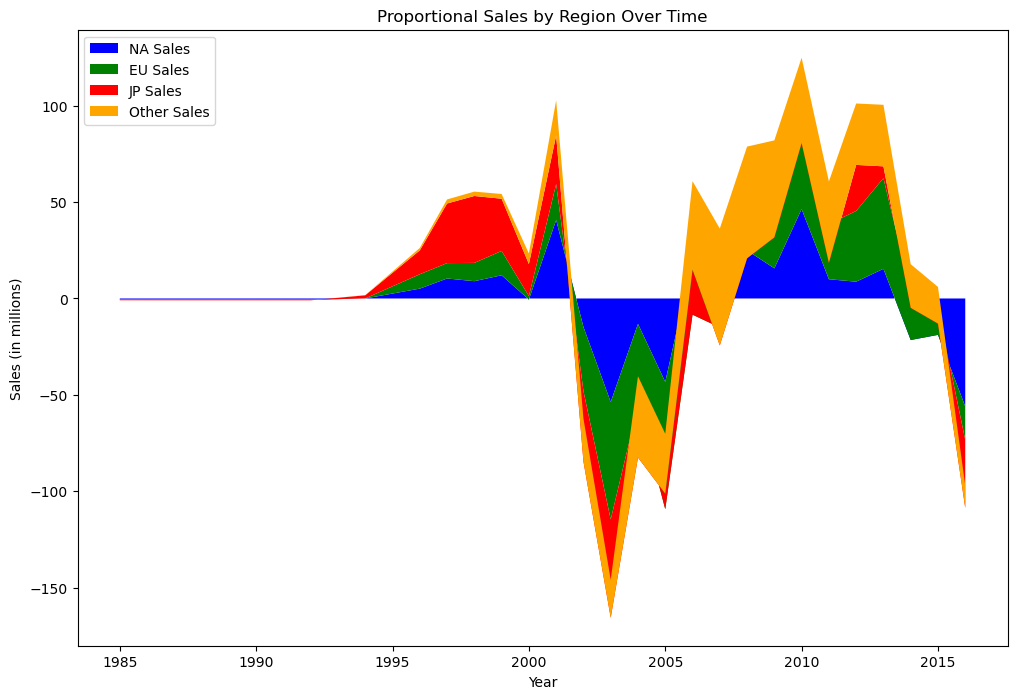

In [75]:
# Proportional Sales by Region
plt.figure(figsize=(12, 8))
plt.stackplot(yearly_sales_by_region.index, 
              yearly_sales_by_region['NA_Sales'], 
              yearly_sales_by_region['EU_Sales'], 
              yearly_sales_by_region['JP_Sales'], 
              yearly_sales_by_region['Other_Sales'], 
              labels=['NA Sales', 'EU Sales', 'JP Sales', 'Other Sales'],
              colors=['blue', 'green', 'red', 'orange'])

plt.title('Proportional Sales by Region Over Time')
plt.xlabel('Year')
plt.ylabel('Sales (in millions)')
plt.legend(loc='upper left')
plt.show()

In [76]:
# Product Performance
# Aggregate total sales by product (game title)
product_sales = Games_df.groupby('Name')[['Global_Sales']].sum()

# Sort products by total sales in descending order
top_products = product_sales.sort_values(by='Global_Sales', ascending=False).head(10)

# Merge with the original DataFrame to get additional characteristics
top_products_details = top_products.merge(Games_df[['Name', 'Platform', 'Genre', 'Publisher', 'Year_of_Release']],
                                          on='Name', how='left').drop_duplicates(subset='Name')


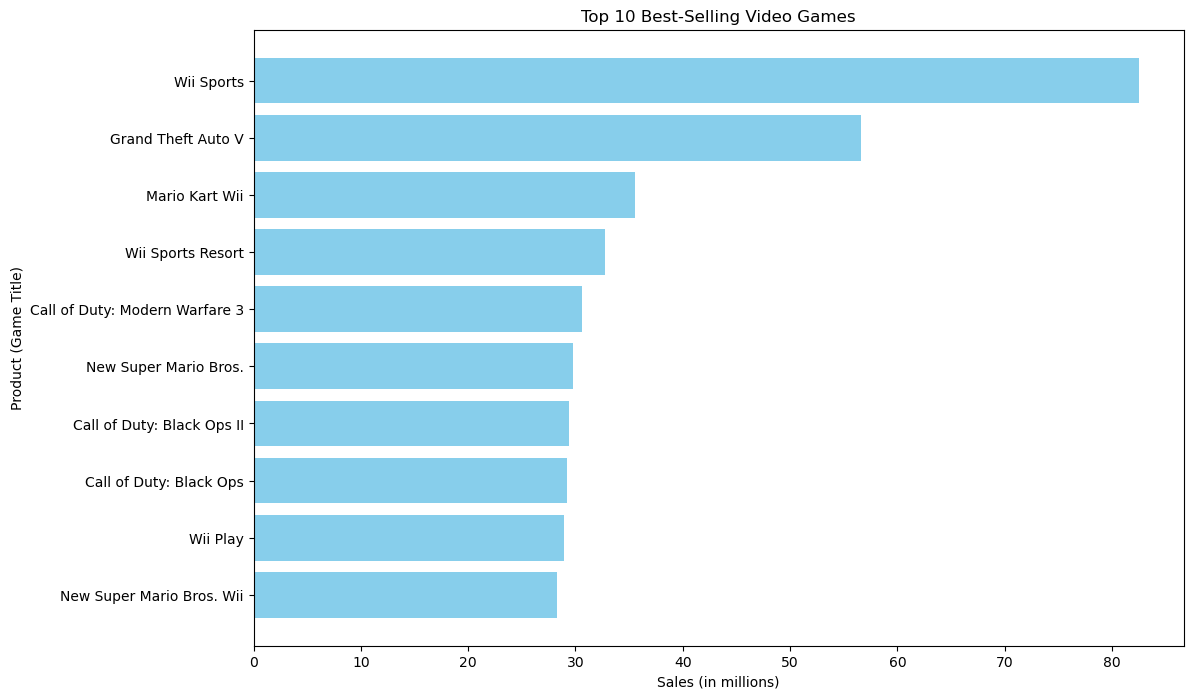

In [77]:
# Best Top Ten Selling Products / Games
plt.figure(figsize=(12, 8))
plt.barh(top_products_details['Name'], top_products_details['Global_Sales'], color='skyblue')
plt.xlabel('Sales (in millions)')
plt.ylabel('Product (Game Title)')
plt.title('Top 10 Best-Selling Video Games')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest sales on top
plt.show()

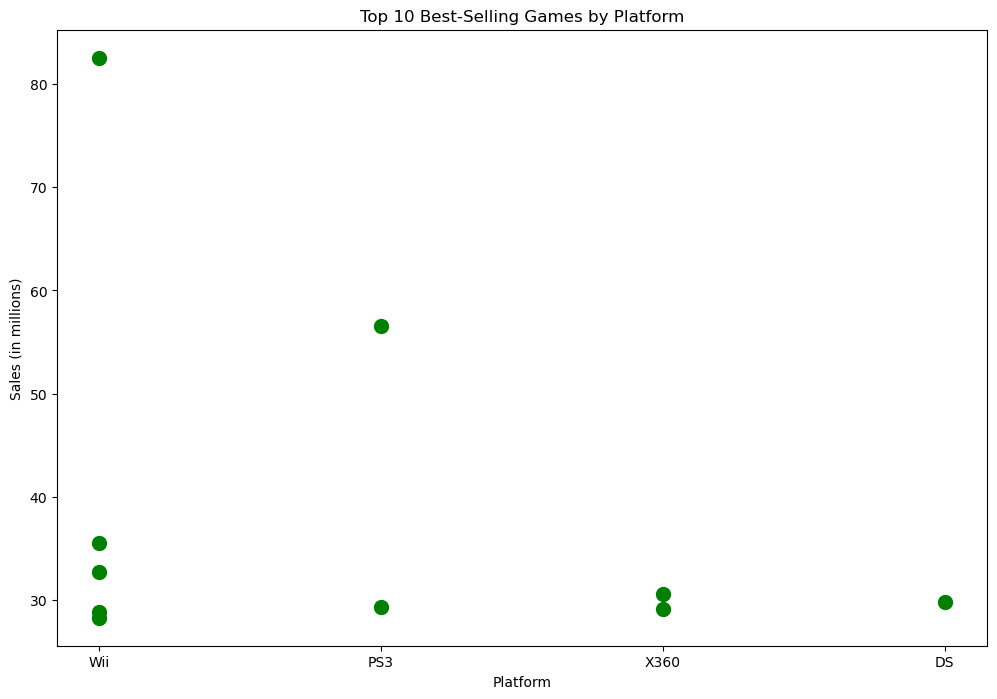

In [78]:
# Sales Characteristics per Platform

plt.figure(figsize=(12, 8))
plt.scatter(top_products_details['Platform'], top_products_details['Global_Sales'], color='green', s=100)
plt.xlabel('Platform')
plt.ylabel('Sales (in millions)')
plt.title('Top 10 Best-Selling Games by Platform')
plt.show()

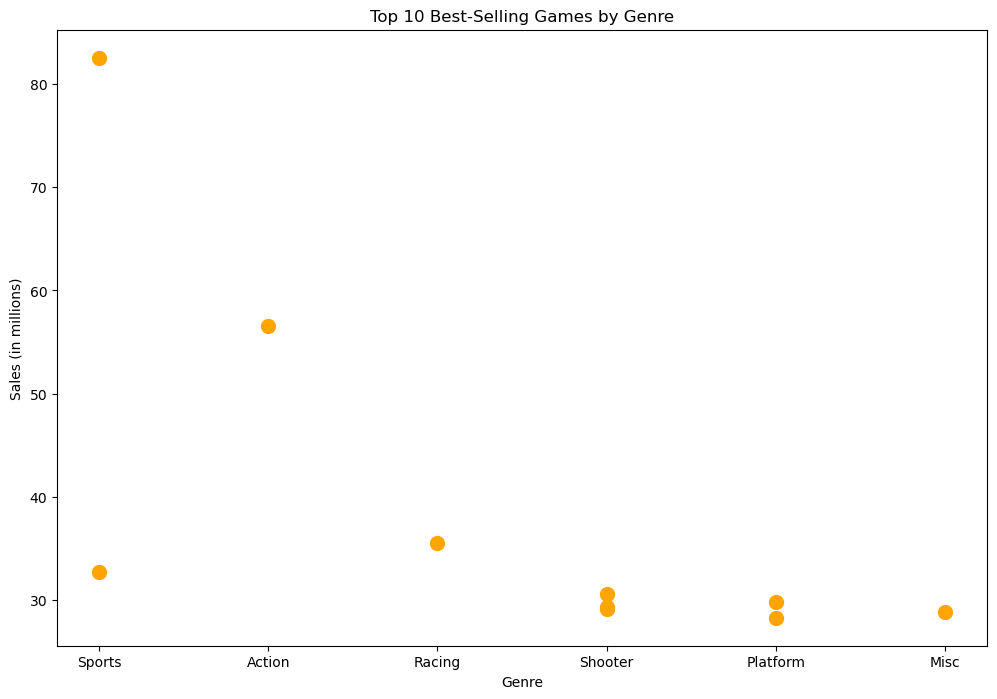

In [80]:
# Scatter Plot by Genre

plt.figure(figsize=(12, 8))
plt.scatter(top_products_details['Genre'], top_products_details['Global_Sales'], color='orange', s=100)
plt.xlabel('Genre')
plt.ylabel('Sales (in millions)')
plt.title('Top 10 Best-Selling Games by Genre')
plt.show()

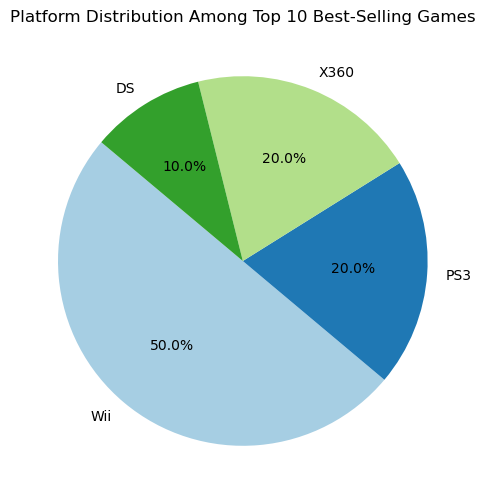

In [81]:
# Platform Distribution and top selling products

platform_distribution = top_products_details['Platform'].value_counts()

plt.figure(figsize=(10, 6))
platform_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Platform Distribution Among Top 10 Best-Selling Games')
plt.ylabel('')
plt.show()

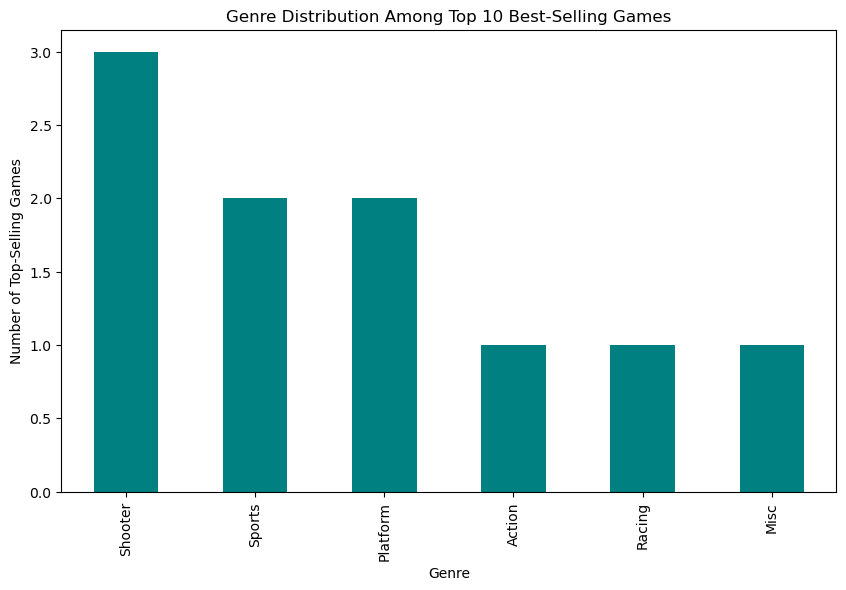

In [82]:
# Genre Distribution
genre_distribution = top_products_details['Genre'].value_counts()

plt.figure(figsize=(10, 6))
genre_distribution.plot(kind='bar', color='teal')
plt.xlabel('Genre')
plt.ylabel('Number of Top-Selling Games')
plt.title('Genre Distribution Among Top 10 Best-Selling Games')
plt.show()